In [ ]:
#Este fragmento de código contiene todas las importaciones necesarias para desarrollar un proyecto de clasificación de imágenes utilizando PyTorch, TorchVision, Scikit-learn, y librerías de visualización como Matplotlib y Seaborn.
#Cada librería cumple un rol específico dentro del pipeline de entrenamiento, evaluación y análisis del modelo.

import matplotlib.pyplot as plt
import os, glob, shutil, json
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix

from google.colab import drive, output
from torchvision import datasets, transforms
from datetime import datetime
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import seaborn as sns


In [ ]:
#En conjunto, estas librerías permiten cargar imágenes, procesarlas, organizarlas por carpetas y preparar el dataset.
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import shutil

In [ ]:
#conectarse al drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Preprocesamiento**
aqui lo que se hizo fue aplicar a cada imagen de las clases un kernel de 3x3 para hacer el realce de bordes y se pueda tener una mejor presición de las iamhenes

In [ ]:
import os
import shutil
import numpy as np
from PIL import Image
from tqdm import tqdm

# === RUTAS ===
BASE_DIR = "/content/drive/MyDrive/proyecto_clase"
LAB_DIR  = f"{BASE_DIR}/labeled"         # tus imágenes originales
OUT_DIR  = f"{BASE_DIR}/data_processed"  # dataset procesado

# Borrar si ya existe
if os.path.exists(OUT_DIR):
    shutil.rmtree(OUT_DIR)

# Crear salida
os.makedirs(OUT_DIR, exist_ok=True)

# === TU KERNEL DE REALCE ===
def convolution2d(image, kernel):
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=2)

    output = np.zeros_like(image)#Matriz donde se guardará la imagen resultante
    image_padded = np.pad(image, ((1, 1), (1, 1), (0, 0)), mode='constant') # Añade un borde de 1 píxel a la imagen para poder aplicar el kernel 3x3

    for c in range(image.shape[2]):  # Recorre cada canal de la imagen (en este caso solo 1)
        for y in range(image.shape[0]): # Recorre filas
            for x in range(image.shape[1]):# Recorre columnas
             # Multiplica el kernel por la región correspondiente de la imagen y suma
                output[y, x, c] = (kernel * image_padded[y:y+3, x:x+3, c]).sum()
    return output # Devuelve la imagen procesada

# Kernel nítido (sharpen)
edge_kernel = np.array([
    [-1, -1, -1],
    [-1,  9, -1],
    [-1, -1, -1]
])

# === RECORRER TODAS LAS CLASES ===
for class_name in os.listdir(LAB_DIR):
    class_path = os.path.join(LAB_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    out_class = os.path.join(OUT_DIR, class_name)# Carpeta equivalente dentro del dataset procesado
    os.makedirs(out_class, exist_ok=True)  # Crea carpeta si no existe

    images = [f for f in os.listdir(class_path)
              if f.lower().endswith(('.jpg', '.png', '.jpeg'))]# Filtra solo imágenes válidas

    print(f"Procesando clase: {class_name} ({len(images)} imágenes)")# Muestra cuántas imágenes tiene esa clase

    for img_name in tqdm(images): # Recorre las imágenes con barra de progreso
        img_path = os.path.join(class_path, img_name)# Ruta completa de la imagen original

        # Abrir imagen en escala de grises
        img = Image.open(img_path).convert('L')
        img_np = np.array(img, dtype=np.float32)

        # Aplicar convolución
        processed = convolution2d(img_np, edge_kernel)
        processed = np.clip(processed, 0, 255).astype(np.uint8).squeeze()

        # Ruta de salida
        out_path = os.path.join(out_class, img_name)

        # === GUARDAR IMAGEN ===
        Image.fromarray(processed).save(out_path)

print("✔ Preprocesamiento completado")
print(f"Imágenes guardadas en: {OUT_DIR}")

Procesando clase: Huecos (150 imágenes)


100%|██████████| 150/150 [21:02<00:00,  8.42s/it]


Procesando clase: Grietas (168 imágenes)


100%|██████████| 168/168 [10:13<00:00,  3.65s/it]


Procesando clase: Calle_Buena (148 imágenes)


100%|██████████| 148/148 [13:07<00:00,  5.32s/it]

✔ Preprocesamiento completado
Imágenes guardadas en: /content/drive/MyDrive/proyecto_clase/data_processed


# Creación del modelo de clasificación

In [ ]:
drive.mount('/content/drive')

PROJECT_DIR = '/content/drive/MyDrive/proyecto_clase'
RAW_DIR     = f'{PROJECT_DIR}/raw'      # imágenes sin etiqueta
LAB_DIR     = f'{PROJECT_DIR}/data_processed'  # imágenes etiquetadas por CLASE/
DATA_DIR    = f'{PROJECT_DIR}/data'     # split final: train/val/test
RUNS_DIR    = f'{PROJECT_DIR}/runs'     # resultados, pesos y configs

for d in [PROJECT_DIR, RAW_DIR, LAB_DIR, DATA_DIR, RUNS_DIR]:
    os.makedirs(d, exist_ok=True)

print("Sube imágenes crudas a:", RAW_DIR)
print("Etiquetado manual: crea subcarpetas dentro de", LAB_DIR, "p.ej.:", LAB_DIR+"/clase_1, clase_2, ...")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sube imágenes crudas a: /content/drive/MyDrive/proyecto_clase/raw
Etiquetado manual: crea subcarpetas dentro de /content/drive/MyDrive/proyecto_clase/data_processed p.ej.: /content/drive/MyDrive/proyecto_clase/data_processed/clase_1, clase_2, ...


In [ ]:
# EDITA con las clases de su proyecto
CLASSES = ['Calle_Buena', 'Grietas',"Huecos"]  # ej: ['sano', 'enfermo']

counts = {}
for c in CLASSES:
    os.makedirs(os.path.join(LAB_DIR, c), exist_ok=True)
    counts[c] = len(glob.glob(os.path.join(LAB_DIR, c, '*')))
counts

{'Calle_Buena': 148, 'Grietas': 168, 'Huecos': 150}

In [ ]:
#Una CNN es una red neuronal que analiza imágenes usando filtros para reconocer patrones y así clasificarlas o identificar lo que aparece en ellas.

# Porcentaje de división para el dataset:
# 70% entrenamiento, 20% validación, 10% prueba
train_r, val_r, test_r = 0.7, 0.2, 0.1

# Si ya existe la carpeta destino (DATA_DIR), se borra completamente
# para volver a generar la estructura desde cero.
if os.path.exists(DATA_DIR):
    shutil.rmtree(DATA_DIR)

# Crear carpetas vacías para cada división (train, val, test)
# y dentro de cada una, una carpeta por clase.
for split in ['train','val','test']:
    for c in CLASSES:
        os.makedirs(os.path.join(DATA_DIR, split, c), exist_ok=True)
# Para cada clase, tomar todas las imágenes disponibles
for c in CLASSES:
    # Obtener lista de archivos de la clase actual
    files = sorted(glob.glob(os.path.join(LAB_DIR, c, '*')))
    # Aviso si una clase tiene muy pocas imágenes
    if len(files) < 20:
        print(f'Clase {c} tiene pocas imágenes ({len(files)}).')

    # Primera división:
    # Separamos train (70%) y el resto (30%) usando train_test_split.
    train_files, tmp = train_test_split(files, test_size=(1-train_r), random_state=42, shuffle=True, stratify=None)
     # Cálculo de proporción exacta entre validación y test:
    # del 30% restante → 20% val y 10% test
    rel = test_r/(val_r + test_r)
     # Segunda división:
    # Dividir ese 30% en validación y prueba según la relación calculada
    val_files, test_files = train_test_split(tmp, test_size=rel, random_state=42, shuffle=True, stratify=None)

    # Copiar los archivos a sus carpetas correspondientes
    for src in train_files:
        shutil.copy(src, os.path.join(DATA_DIR, 'train', c, os.path.basename(src)))
    for src in val_files:
        shutil.copy(src, os.path.join(DATA_DIR, 'val', c, os.path.basename(src)))
    for src in test_files:
        shutil.copy(src, os.path.join(DATA_DIR, 'test', c, os.path.basename(src)))
# Mensaje de confirmación
print("Split en", DATA_DIR)

Split en /content/drive/MyDrive/proyecto_clase/data


In [ ]:
#Este bloque configura el entorno para entrenar la CNN: define si se usará CPU o GPU, establece el tamaño de las imágenes y el batch, aplica transformaciones como redimensionar, normalizar y voltear imágenes para mejorar el entrenamiento,
#carga los datasets de entrenamiento/validación/prueba y finalmente crea los DataLoaders que alimentan las imágenes al modelo en lotes durante el entrenamiento.

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

IMG_SIZE = 224
BATCH_SIZE = 32

# Normalización estándar
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),# Redimensiona imágenes
    transforms.RandomHorizontalFlip(),  # Aumenta datos invirtiendo imágenes horizontalmente
    transforms.ToTensor(), # Convierte a tensor
    transforms.Normalize(mean, std)  # Normaliza valores
])
eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),# Solo redimensiona y normaliza (sin aumentos)
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
# Carga los datasets desde las carpetas
train_ds = datasets.ImageFolder(f"{DATA_DIR}/train", transform=train_tf)
val_ds   = datasets.ImageFolder(f"{DATA_DIR}/val",   transform=eval_tf)
test_ds  = datasets.ImageFolder(f"{DATA_DIR}/test",  transform=eval_tf)

class_names = train_ds.classes
num_classes = len(class_names)

# DataLoaders: cargan imágenes en lotes
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Clases:", class_names, "| Dispositivo:", DEVICE)


Clases: ['Calle_Buena', 'Grietas', 'Huecos'] | Dispositivo: cpu


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


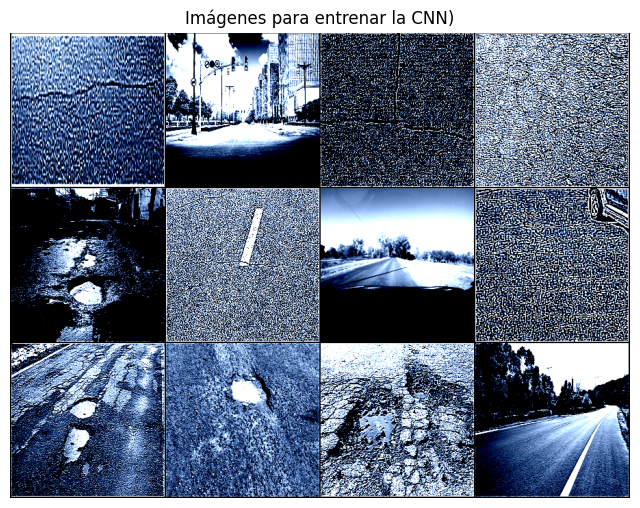

Etiquetas: ['Grietas', 'Calle_Buena', 'Grietas', 'Grietas', 'Huecos', 'Grietas', 'Huecos', 'Grietas', 'Huecos', 'Huecos', 'Huecos', 'Calle_Buena']


In [ ]:
#Este código toma un lote de imágenes del DataLoader, crea una cuadrícula con las primeras 12 y la muestra para visualizar cómo llegan al modelo después de las transformaciones.
#También imprime las etiquetas reales de esas imágenes para verificar que el dataset está cargado correctamente.
images, labels = next(iter(train_dl)) # Imágenes normalizadas
grid = torchvision.utils.make_grid(images[:12], nrow=4, padding=2)# Crea una cuadrícula con 12 imágenes
npimg = grid.cpu().numpy().transpose(1, 2, 0)# Convierte el tensor a NumPy y ajusta ejes para mostrar

plt.figure(figsize=(8, 8))
plt.imshow(npimg)
plt.title("Imágenes para entrenar la CNN)")
plt.axis("off")
plt.show()

print("Etiquetas:", [class_names[i] for i in labels[:12]])# Muestra las clases de esas 12 imágenes

# **Creación de CNN**
Esta CNN toma imágenes y las pasa por tres bloques de convolución y max-pooling para extraer características. Luego aplana la salida y pasa por tres capas totalmente conectadas que clasifican la imagen en una de tres clases. Incluye una capa dropout para reducir sobreajuste.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.dropout = nn.Dropout(0.5)# Evita sobreentrenamiento

      #Tres capas de convolución + max pooling
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1) # Extrae primeros patrones
        self.pool1 = nn.MaxPool2d(2) # Reduce tamaño a la mitad

        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)# Extrae características más profundas
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)# Extrae patrones complejos
        self.pool3 = nn.MaxPool2d(2)

        # Capa completamente conectada (clasificador)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)# Combina características
        self.fc2 = nn.Linear(256, 512)# Aprende relaciones internas
        self.fc3 = nn.Linear(512, 3) # Output: 3 clases

    def forward(self, x):
      # Activación ReLU + reducción
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        # Aplanar
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))# Neuronas densas
        x = self.dropout(x) # Dropout para regularizar
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Última capa sin activación (CrossEntropy la aplica)

        return x

In [ ]:
cnn = CNN() #Aqui estamos cargando el modelo
cnn

CNN(
  (dropout): Dropout(p=0.5, inplace=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=3, bias=True)
)

# **Funcion de perdida**
Se define la función de pérdida CrossEntropyLoss, usada para clasificar imágenes, y se crea el optimizador Adam, que ajusta los pesos de la red durante el entrenamiento usando una tasa de aprendizaje de 0.001.

In [ ]:
loss_function = nn.CrossEntropyLoss()#funcion de perdida
optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.001)
print('Optimizer: ', optimizer)

Optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


# **Entrenamiento**
Se entrena la CNN durante varias épocas (25) calculando la pérdida y actualizando los pesos. Después de cada época, se evalúa en el conjunto de validación para medir pérdida y precisión. Si la precisión supera 85%, se guardan los pesos del modelo. Si llega a 90%, el entrenamiento se detiene automáticamente (early stopping).

In [ ]:
num_epochs = 25 #número máximo de épocas de entrenamiento.

#guardan la pérdida por época para luego graficar o analizar.
train_losses = []
val_losses = []

cnn.train()#pone la red en modo entrenamiento (activa dropout, batchnorm, etc.).
total_step = len(train_dl)#cantidad de lotes (batches) por época.
print(len(train_dl))

#Se inicia el entrenamiento por cada época y se reinicia la pérdida acumulada.
for epoch in range(num_epochs):
    running_loss = 0.0


    for i, data in enumerate(train_dl, 0):#carga lotes de imágenes y etiquetas.
        inputs, labels = data
        output = cnn(inputs)#la red predice la clase.

        loss = loss_function(output, labels)#Usa CrossEntropyLoss para medir qué tan mal predice la red.

        optimizer.zero_grad()#limpia gradientes anteriores.
        loss.backward()#calcula gradientes.
        optimizer.step()#actualiza los pesos de la red.

        running_loss += loss.item()#Suma la pérdida de cada batch para obtener el promedio final de la época.
        if (i+1) % 100 == 0:#Solo muestra el avance del entrenamiento.
            print('Época [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    #Calcula la pérdida promedio de toda la época.
    #Se guarda para graficarla luego.
    epoch_loss = running_loss / len(train_dl)
    train_losses.append(epoch_loss)

    print(f' Época [{epoch + 1}/{num_epochs}], Pérdida promedio : {epoch_loss:.4f}')

    cnn.eval()#eval() activa el modo evaluación (desactiva dropout).
    val_running_loss = 0.0
    correct = 0
    total = 0

    #no_grad() evita calcular gradientes → mucho más rápido.
    with torch.no_grad():
        for data in val_dl:
            images, labels = data

            outputs = cnn(images)

            #Cálculo de la pérdida de validación
            val_loss = loss_function(outputs, labels)
            val_running_loss += val_loss.item()

            #Cálculo de la precisión
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    #Resultados de validación
    #Guarda pérdida promedio y precisión.
    avg_val_loss = val_running_loss / len(val_dl)
    val_losses.append(avg_val_loss)

    accuracy = 100 * correct / total

    print(f'Validación -> Pérdida en la validación: {avg_val_loss:.4f}, Precisión: {accuracy:.2f}%')

     # ---- Guardar pesos si precisión > 85% ----
    if accuracy >= 85:
        os.makedirs("checkpoints", exist_ok=True)
        checkpoint_path = f"checkpoints/model_epoch_{epoch+1}_acc_{accuracy:.2f}.pth"
        torch.save(cnn.state_dict(), checkpoint_path)
        print(f'Pesos guardados: {checkpoint_path}')


    # ---- Condición de parada temprana ----
    if accuracy >= 90:
      print(f'Precisión del {accuracy:.2f}% alcanzada en la época {epoch + 1}. Entrenamiento detenido.')
      break

  #Volver a modo entrenamiento
    cnn.train()

print('Entrenamiento finalizado.')

11
 Época [1/25], Pérdida promedio : 1.1305
Validación -> Pérdida en la validación: 0.7126, Precisión: 68.09%
 Época [2/25], Pérdida promedio : 0.7750
Validación -> Pérdida en la validación: 0.6885, Precisión: 68.09%
 Época [3/25], Pérdida promedio : 0.6605
Validación -> Pérdida en la validación: 0.7320, Precisión: 68.09%
 Época [4/25], Pérdida promedio : 0.6311
Validación -> Pérdida en la validación: 0.5976, Precisión: 76.60%
 Época [5/25], Pérdida promedio : 0.5184
Validación -> Pérdida en la validación: 0.5847, Precisión: 79.79%
 Época [6/25], Pérdida promedio : 0.4620
Validación -> Pérdida en la validación: 0.5092, Precisión: 80.85%
 Época [7/25], Pérdida promedio : 0.3689
Validación -> Pérdida en la validación: 0.5174, Precisión: 82.98%
 Época [8/25], Pérdida promedio : 0.4126
Validación -> Pérdida en la validación: 0.6617, Precisión: 70.21%
 Época [9/25], Pérdida promedio : 0.4543
Validación -> Pérdida en la validación: 0.5389, Precisión: 78.72%
 Época [10/25], Pérdida promedio :

80.85106382978724


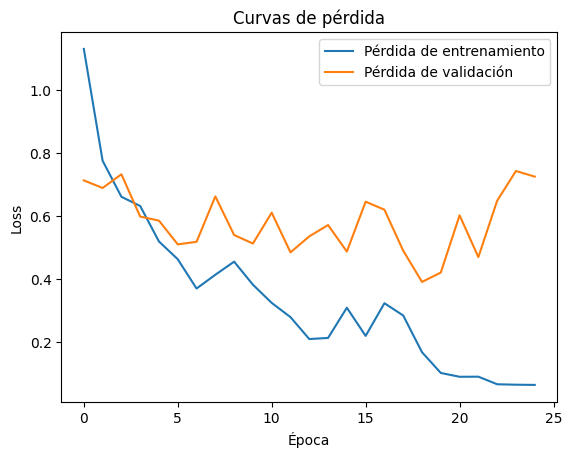

In [ ]:
#GRÁFICA CURVA DE PERDIDA
print(accuracy)
plt.plot(train_losses, label='Pérdida de entrenamiento')
plt.plot(val_losses, label='Pérdida de validación')

plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curvas de pérdida')

plt.legend()
plt.show()

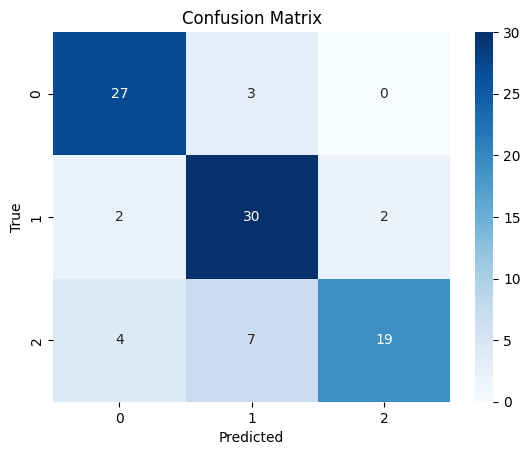

In [ ]:
# ====== MATRIZ DE CONFUSIÓN ================================================
cnn.eval()  # modo evaluación
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_dl:
        outputs = cnn(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())    # guarda las predicciones
        all_labels.extend(labels.numpy())  # guarda las etiquetas reales

# Aqui creamos la matriz de confusion
cm = confusion_matrix(all_labels, all_preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Se entrena la CNN durante varias épocas calculando la pérdida y actualizando los pesos. Después de cada época, se evalúa en el conjunto de validación para medir pérdida y precisión.
#Si la precisión supera 85%, se guardan los pesos del modelo. Si llega a 90%, el entrenamiento se detiene automáticamente (early stopping).
os.makedirs(RUNS_DIR, exist_ok=True)

# Pesos (state_dict)
weights_path = f"{RUNS_DIR}/best_model.pt"
torch.save(cnn.state_dict(), weights_path)

# Config mínima
config = {
    "img_size": IMG_SIZE,
    "batch_size": BATCH_SIZE,
    "epochs": num_epochs,
    "arch": "TinyCNN",
    "num_classes": len(class_names),
    "mean": [0.485, 0.456, 0.406],
    "std":  [0.229, 0.224, 0.225],
    "saved_at": datetime.now().isoformat()
}
# Orden de clases
with open(f"{RUNS_DIR}/config.json", "w") as f:
    json.dump(config, f, indent=2)

# Orden de clases
with open(f"{RUNS_DIR}/classes.json", "w") as f:
    json.dump(class_names, f, indent=2)

print("Guardados en RUNS_DIR:")
print(" -", weights_path)
print(" -", f"{RUNS_DIR}/config.json")
print(" -", f"{RUNS_DIR}/classes.json")


Guardados en RUNS_DIR:
 - /content/drive/MyDrive/proyecto_clase/runs/best_model.pt
 - /content/drive/MyDrive/proyecto_clase/runs/config.json
 - /content/drive/MyDrive/proyecto_clase/runs/classes.json
